In [186]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gym_tetris.actions import SIMPLE_MOVEMENT

In [187]:
def calc_iqm(data):
    sorted_data = np.sort(data)

    q1 = np.percentile(sorted_data, 25)
    q3 = np.percentile(sorted_data, 75)

    interquartile_range = sorted_data[(sorted_data >= q1) & (sorted_data <= q3)]

    return interquartile_range.mean()

In [188]:
def confidence_intervals(population,  parameter, n_sample = 100, iterasi=5000, alpha=0.05, stratified=False, aggregate = "iqm"):
    stats = np.array([])

    for _ in range(iterasi):
        if not stratified:
            sample = population[parameter].sample(n_sample, replace=True)
        else:
            sample = population.groupby('level', group_keys=False).apply(lambda x: x[parameter].sample(n=200, replace=True), include_groups=False).reset_index(drop=True)
        if aggregate == "iqm":
            stat = calc_iqm(sample)
        elif aggregate == "mean":
            stat = np.mean(sample)
        elif aggregate == "median":
            stat = np.median(sample)
        stats = np.append(stats, stat)

    lower_bound = np.percentile(stats, 100 * alpha / 2)
    upper_bound = np.percentile(stats, 100 * (1 - alpha / 2))
    
    return stats, lower_bound, upper_bound, np.mean(stats), np.std(stats)

In [189]:
def plot_interval(df: pd.DataFrame, title: str, metrics: list = [], levels: list = [], agg = "IQM"):
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), max(len(levels) * .5, 4)))
    axes = [axes] if len(metrics) == 1 else axes.flatten()

    color_palette = sns.color_palette('colorblind', n_colors=len(levels))
    colors = dict(zip(levels, color_palette))

    for m_idx, metric_name in enumerate(metrics): # IQM, mean, median dari suatu parameter
        ax = axes[m_idx]
        sub_df = df[df["parameter"] == metric_name]
        x_min, x_max = sub_df["lower_bound"].min(), sub_df["upper_bound"].max()
        ci_range = x_max - x_min
        padding = ci_range * .2
        ax.set_xlim(x_min - padding, x_max + padding)

        for idx, level in enumerate(levels): # biasanya level
            level_data = sub_df[sub_df["level"] == level]
            lower = level_data["lower_bound"].values[0]
            upper = level_data["upper_bound"].values[0]
            mean = level_data["mean"].values[0]
            
            # Plotkan interval kepercayaan untuk metrik (bar horizontal)
            ax.barh(y=idx, width=upper - lower, left=lower, height=0.7, alpha=0.75, color=colors[level], label=f'{metric_name} Interval' if idx == 0 else "")
            # Plotkan nilai rata-rata untuk metrik (garis vertikal)
            ax.vlines(x=mean, ymin=idx - 0.3, ymax=idx + 0.3, color='k', alpha=0.7)

        ax.set_yticks(list(range(len(levels))))
        ax.set_xticks(np.linspace(x_min, x_max, 100))
        ax.xaxis.set_major_locator(plt.MaxNLocator(8))
        # Set label untuk subplot
        if m_idx == 0:
            ax.set_yticklabels(levels, fontsize="medium")
            ax.set_ylabel("Level")
        else:
            ax.set_yticklabels([])

        ax.set_xlabel(f"{metric_name.replace('_', ' ').capitalize()} ({agg})")
        # ax.set_title(f"{metric_name.replace('_', ' ').capitalize()} {title}", fontsize='x-large')
        
        ax.tick_params(axis='both', which='major', length=0 if m_idx != 0 else 5)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(True, axis='x', alpha=0.25)
        
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])  # Menghapus subplot yang tidak digunakan

    # Coba gunakan tight_layout() untuk penyesuaian otomatis layout
    fig.text(0.46, 1, f"{title}", ha='center', fontsize='xx-large')
    # fig.suptitle(f"{title}", fontsize='xx-large')
    # plt.tight_layout(w_pad=3)  # Mengatur jarak antar subplot dengan padding
    plt.subplots_adjust(wspace=0.12, hspace=0.05, left=0.0)

    return fig, axes

In [190]:
def validate_95_percent_ci(data, lower_bound, upper_bound):
    count_in_range = np.sum((data >= lower_bound) & (data <= upper_bound))
    proportion_in_range = count_in_range / len(data)
    return proportion_in_range

In [191]:
def parse_board_heatmap(string_array):
    clean_str = string_array.replace('array(', '').replace(', dtype=uint8)', '').replace('\n', '')
    return np.array(ast.literal_eval(clean_str))

In [192]:
data = []
action_data = []
for i in range(10):
    df = pd.read_csv(f"./UNREAL-eval/transfer/csv/{i+1}.csv")
    df["level"] = 10 + i
    df["lines_history"] = df["lines_history"].apply(lambda x: ast.literal_eval(x))
    df["board_history"] = df["board_history"].apply(parse_board_heatmap).apply(lambda x: np.sum(x, axis=0))
    
    action_freq = np.array([
        [seq.count(str(action)) for action in range(6)] for seq in df["action_taken"]
    ])
    total_action_freq = action_freq.sum(axis=0)

    action_freq_df = pd.DataFrame([total_action_freq], columns=[' '.join(item) for item in SIMPLE_MOVEMENT])
    action_freq_df["level"] = i + 10

    data.append(df)
    action_data.append(action_freq_df)

data = pd.concat(data, ignore_index=True)
action_data = pd.concat(action_data, ignore_index=True)

In [193]:
LINE_REWARDS = {1: 40, 2: 100, 3: 300, 4: 1200}

In [194]:
data["scaled_rewards"] = data.apply(
    lambda row: row["score"] + row["block_placed"] * 0.5 - row["level"] * sum(
        [LINE_REWARDS[line] for line in row["lines_history"]]
    ), axis=1
)
data["softdrop_rewards"] = data.apply(
    lambda row: row["score"] - (row["level"] + 1) * sum(
        [LINE_REWARDS[line] for line in row["lines_history"]]
    ), axis=1
)

In [195]:
max_r = data["scaled_rewards"].max()
min_r = data["scaled_rewards"].min()
data["normalized_rewards"] = data["scaled_rewards"].apply(
    lambda row: (row - min_r) / (max_r- min_r)
)

In [196]:
data.head()

,lines,score,rewards,block_placed,episode_time,episode_length,action_taken,lines_history,board_history,level,scaled_rewards,softdrop_rewards,normalized_rewards
0,0,0,-219.55,35,29.482152,2406,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 0, 4, 0, 2, 2, 2, 2, 3], [0, 9, 0, 4, ...",10,17.5,0,0.074627
1,0,0,-214.00,34,27.220049,2337,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, ...",10,17.0,0,0.070896
2,0,0,-220.00,32,61.389469,2230,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 2, 2, 2, 1, 1, 1, 0, 0], [0, 0, 0, 6, ...",10,16.0,0,0.063433
3,0,1,-202.39,24,25.374547,1799,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, ...",10,13.0,1,0.041045
4,0,0,-198.79,29,38.133629,2139,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",10,14.5,0,0.052239


In [197]:
data.iloc[119]

lines                                                                 0
score                                                                 0
rewards                                                         -208.78
block_placed                                                         24
episode_time                                                   22.11437
episode_length                                                     1425
action_taken          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
lines_history                                                        []
board_history         [[0, 0, 1, 1, 1, 0, 0, 0, 0, 0], [2, 2, 2, 2, ...
level                                                                13
scaled_rewards                                                     12.0
softdrop_rewards                                                      0
normalized_rewards                                             0.033582
Name: 119, dtype: object

In [198]:
data.to_csv(f"./UNREAL-eval/transfer/master.csv")

In [228]:
data = pd.read_csv("./UNREAL-eval/uncertainty/master.csv")

In [229]:
cumsum_data = data.groupby('level')[["block_placed", "lines", "scaled_rewards", "softdrop_rewards"]].cumsum()
cumsum_data.columns = ["cumsum_blocks", "cumsum_lines", "cumsum_scaled_rewards", "cumsum_softdrop_rewards"]
cumsum_data["level"] = data["level"]

In [230]:
cumsum_data.groupby('level')["cumsum_lines"].max()

level
10    15
11     6
12     9
13     8
14     7
15     6
16     8
17     5
18    12
19     4
Name: cumsum_lines, dtype: int64

In [234]:
action_data = []
for level in data["level"].unique():
    df = data[data["level"] == level]
    action_freq = np.array([
        [seq.count(str(action)) for action in range(6)] for seq in df["action_taken"]
    ])
    total_action_freq = action_freq.sum(axis=0)

    action_freq_df = pd.DataFrame([total_action_freq], columns=[' '.join(item) for item in SIMPLE_MOVEMENT])
    action_freq_df["level"] = level
    action_data.append(action_freq_df)

action_data = pd.concat(action_data, ignore_index=True)

In [235]:
action_data = action_data.set_index("level")
action_data.head()

,NOOP,A,B,right,left,down
level,,,,,,
10,3432,8969,469,9151,13021,801
11,2021,2876,70,9741,12535,238
12,3996,8937,171,7259,10439,913
13,2098,8186,448,8079,10076,312
14,2446,8011,558,7139,8975,525


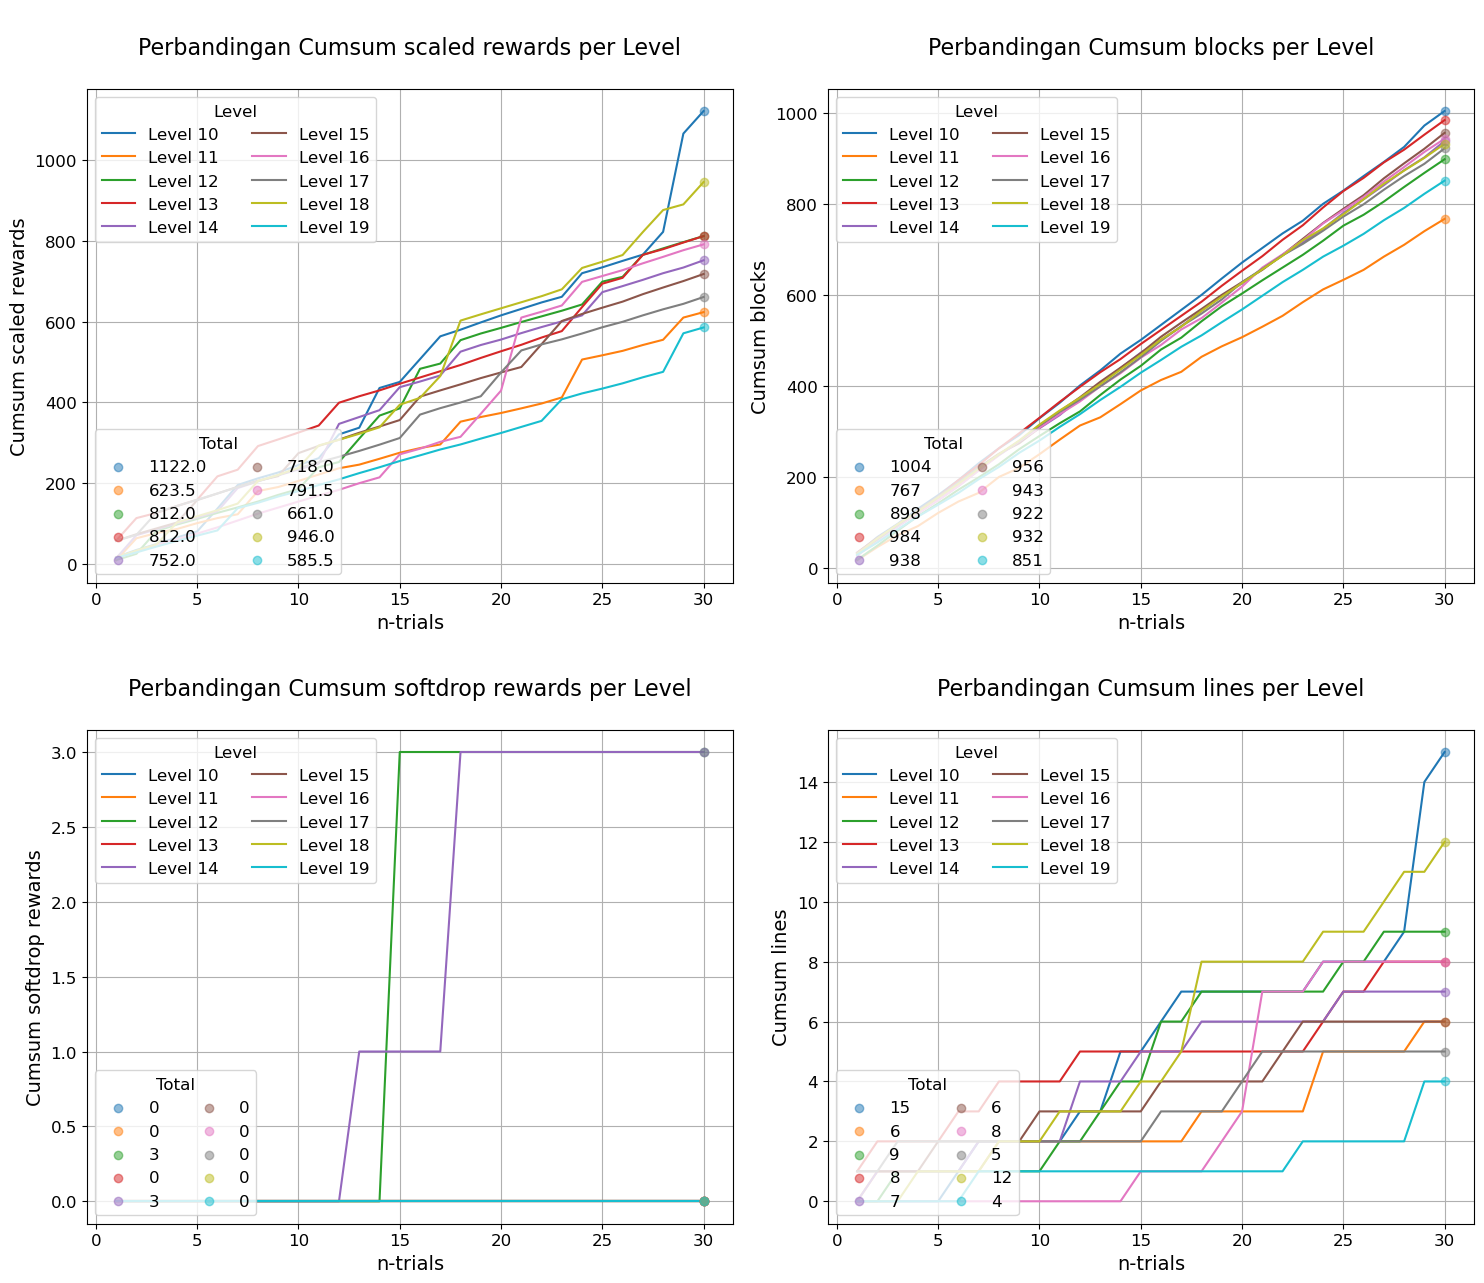

In [236]:
plt.rcParams.update({
    'font.size': 12,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 12,    # Ukuran font legend
})
metrics = ['cumsum_scaled_rewards', 'cumsum_blocks', 'cumsum_softdrop_rewards', 'cumsum_lines']

# Membuat subplot untuk setiap metrik
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 13))
axes = axes.flatten()  # Mengubah axes menjadi array 1D untuk memudahkan iterasi

# Plotting untuk setiap metrik
for i, metric in enumerate(metrics):
    lines = []  # Untuk menyimpan objek line
    dots = []   # Untuk menyimpan objek dot
    for level in range(10):
        level_data = cumsum_data[cumsum_data['level'] == level + 10]
        line, = axes[i].plot(range(1, len(level_data) + 1), level_data[metric], label=f"Level {level + 10}")
        lines.append(line)
        max_value = level_data[metric].max()  # Ambil nilai maksimum
        dot = axes[i].scatter(30, max_value, zorder=10, label=f'{max_value}', alpha=0.5) # Plot titik tertinggi
        dots.append(dot)

    metric = metric.replace("_", " ").capitalize()
    axes[i].set_title(f'\nPerbandingan {metric} per Level\n')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('n-trials')
    legend1 = axes[i].legend(handles=lines, loc='upper left', title='Level', ncol=2)
    axes[i].add_artist(legend1)  # Menambahkan legend pertama ke axes

    # Membuat legend kedua (Max Value)
    legend2 = axes[i].legend(handles=dots, loc='lower left', title='Total', ncol=2)
    axes[i].grid(True)  # Menambahkan grid untuk memudahkan pembacaan
    axes[i].set_xticks([1] + list(range(5, 31, 5)))

    axes[i].xaxis.set_major_locator(plt.MaxNLocator(7))
plt.tight_layout()  # Agar subplot tidak tumpang tindih
plt.show()

In [238]:
cumsum_data.groupby('level')["cumsum_scaled_rewards"].max()

level
10    1122.0
11     623.5
12     812.0
13     812.0
14     752.0
15     718.0
16     791.5
17     661.0
18     946.0
19     585.5
Name: cumsum_scaled_rewards, dtype: float64

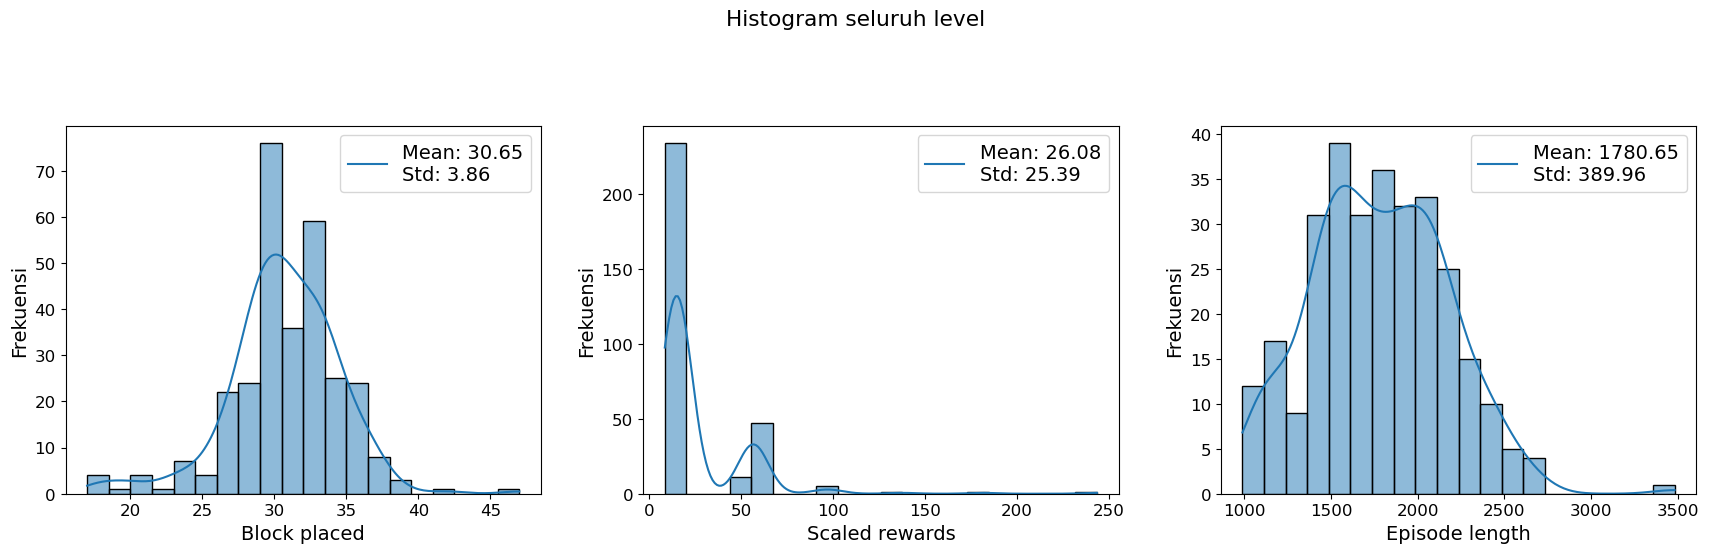

In [239]:
plt.rcParams.update({
    'font.size': 13,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 14,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    # Membuat histogram distribusi data
    mean = data[data["level"] != 9][parameter].mean()
    std = data[data["level"] != 9][parameter].std()
    sns.histplot(data[data["level"] != 9][parameter], bins=20, kde=True, stat="count", ax=axes[i])
    label = f'Mean: {mean:.2f}\nStd: {std:.2f}'

    # Menambahkan keterangan (legend)
    axes[i].legend([label], loc='upper right', fontsize=14)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'{parameter.replace("_", " ").capitalize()}')
    axes[i].set_ylabel('Frekuensi')

plt.suptitle('Histogram seluruh level')
plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)
plt.show()

In [240]:
generalized_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std = confidence_intervals(data[data["level"] != 9], parameter, stratified=True, aggregate="iqm")
    generalized_data.append([stats, lb, ub, mean, std, parameter])

generalized_df = pd.DataFrame(generalized_data, columns=["stat", "lower_bound", "upper_bound", "mean", "std", "parameter"]).drop(columns=["stat"])
generalized_df["level"] = "10 - 19"
generalized_df.head()

,lower_bound,upper_bound,mean,std,parameter,level
0,30.792888,30.952301,30.870068,0.042332,block_placed,10 - 19
1,15.536515,15.730775,15.630732,0.053334,scaled_rewards,10 - 19
2,1762.098560,1784.528097,1773.236364,5.761228,episode_length,10 - 19


(<Figure size 1800x400 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)'>], dtype=object))

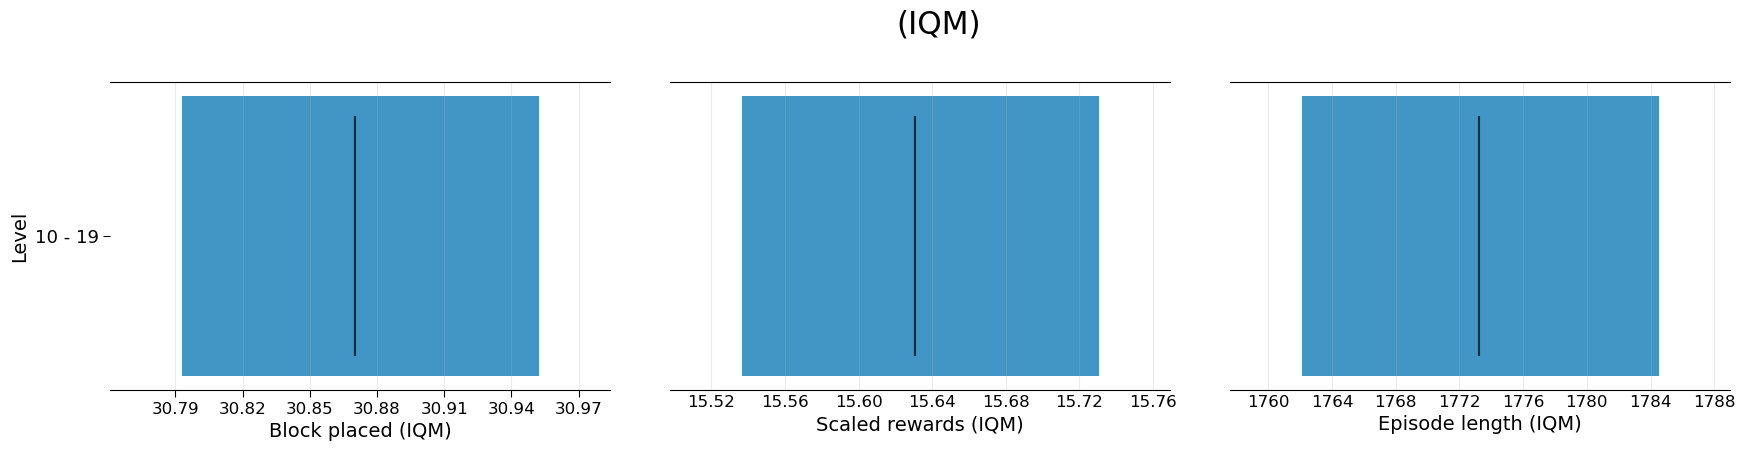

In [241]:
plot_interval(generalized_df, "(IQM)", generalized_df.parameter.unique(), generalized_df.level.unique())

Percentage: 95.0%
Percentage: 95.0%
Percentage: 95.0%


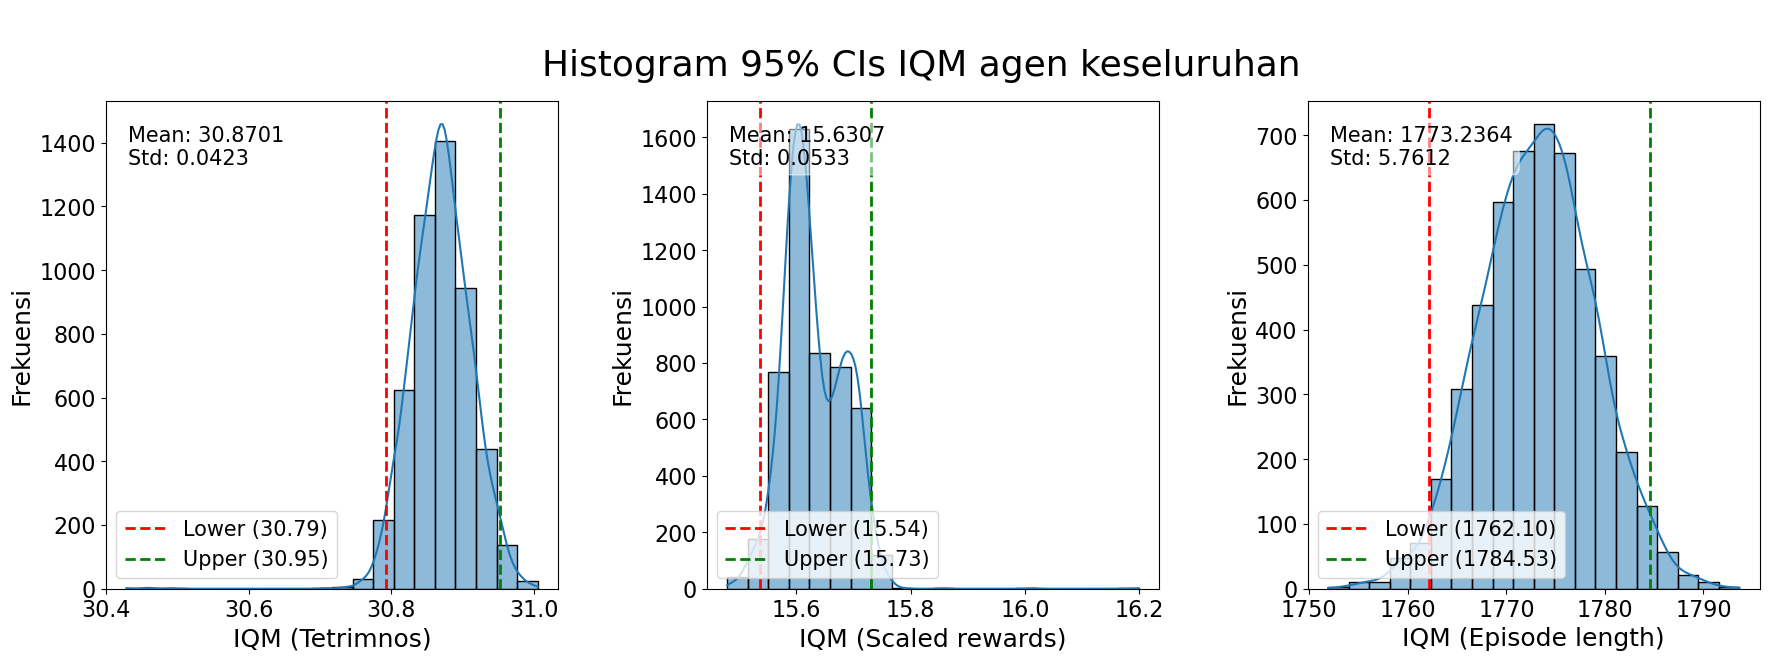

In [242]:
plt.rcParams.update({
    'font.size': 18,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 18,     # Ukuran font label sumbu
    'xtick.labelsize': 16,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 16,    # Ukuran font tick label sumbu y
    'legend.fontsize': 18,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
axes = axes.flatten()
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std, _ = generalized_data[i]

    # Membuat histogram distribusi data
    sns.histplot(stats, ax=axes[i], kde=True, stat="count", bins=20)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.4f}\nStd: {std:.4f}', transform=axes[i].transAxes,
            fontsize=15, va='top', ha='left', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='lower left', fontsize=15)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'IQM ({parameter.replace("_", " ").capitalize() if i != 0 else "Tetrimnos"})')
    axes[i].set_ylabel('Frekuensi')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")

# plt.tight_layout()  # Mengatur layout agar tidak overlap
fig.text(0.52, 1, f"\nHistogram 95% CIs IQM agen keseluruhan", ha='center', fontsize='x-large')
plt.tight_layout(pad=1.0, w_pad=2.0)
plt.show()

In [208]:
generalized_data_mean = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std = confidence_intervals(data[data["level"] != 9], parameter, stratified=True, aggregate="mean")
    generalized_data_mean.append([stats, lb, ub, mean, std, parameter])

generalized_df_mean = pd.DataFrame(generalized_data_mean, columns=["stat", "lower_bound", "upper_bound", "mean", "std", "parameter"]).drop(columns=["stat"])
generalized_df_mean["level"] = "10 - 19"
generalized_df_mean.head()

,lower_bound,upper_bound,mean,std,parameter,level
0,29.946987,30.260000,30.106252,0.079526,block_placed,10 - 19
1,24.864975,26.721506,25.777180,0.466124,scaled_rewards,10 - 19
2,1742.671300,1760.882175,1751.536511,4.626723,episode_length,10 - 19


(<Figure size 1800x400 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)'>], dtype=object))

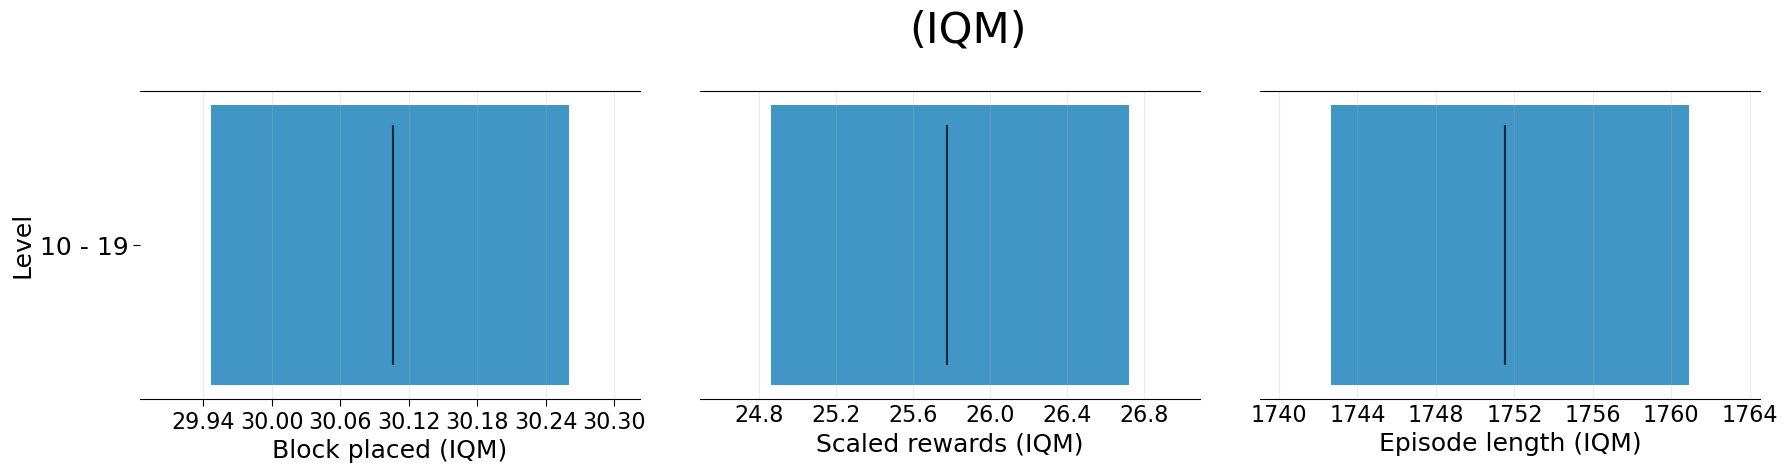

In [209]:
plot_interval(generalized_df_mean, "(IQM)", generalized_df_mean.parameter.unique(), generalized_df_mean.level.unique())

Percentage: 95.02000000000001%
Percentage: 95.0%
Percentage: 95.0%


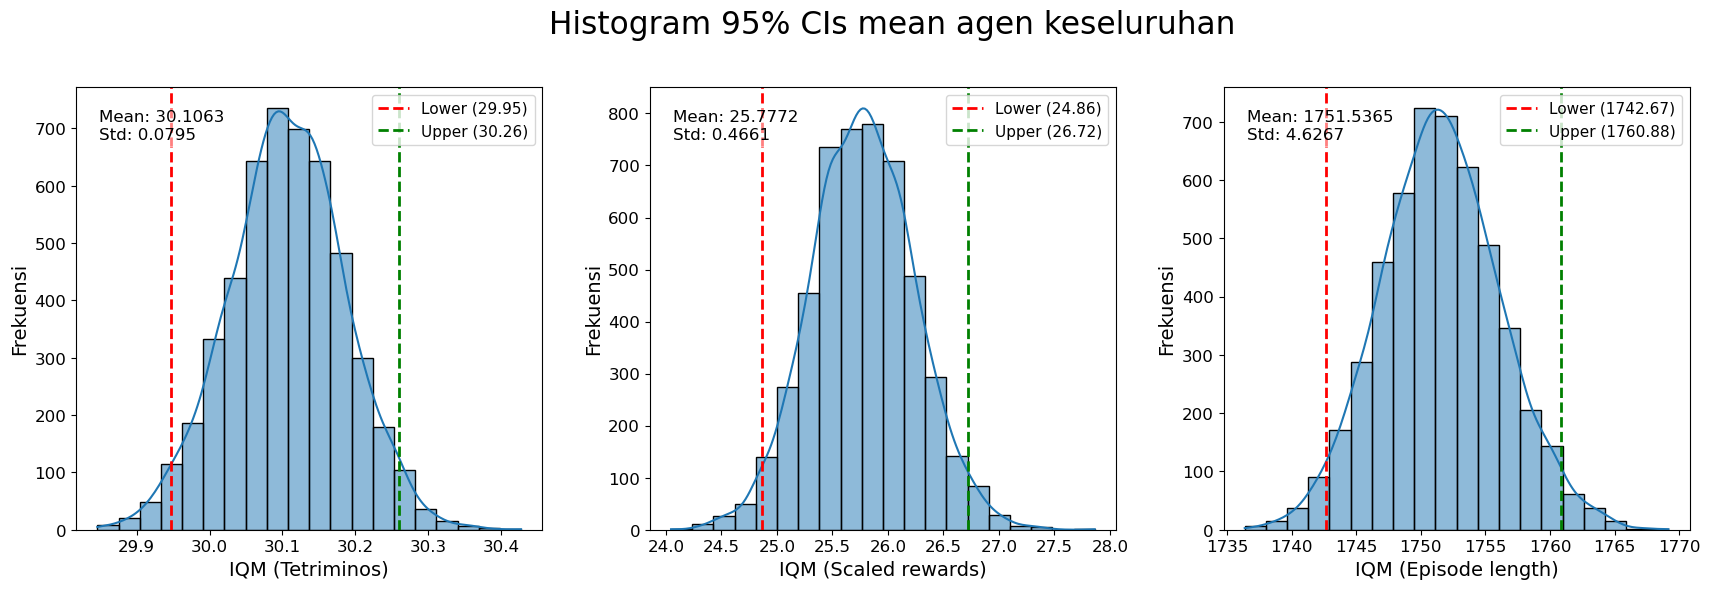

In [210]:
plt.rcParams.update({
    'font.size': 13,          # Ukuran font default
    'axes.titlesize': 16,     # Ukuran font judul plot
    'axes.labelsize': 14,     # Ukuran font label sumbu
    'xtick.labelsize': 12,    # Ukuran font tick label sumbu x
    'ytick.labelsize': 12,    # Ukuran font tick label sumbu y
    'legend.fontsize': 12,    # Ukuran font legend
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 baris, 2 kolom
axes = axes.flatten()
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    stats, lb, ub, mean, std, _ = generalized_data_mean[i]

    # Membuat histogram distribusi data
    sns.histplot(stats, ax=axes[i], kde=True, stat="count", bins=20)

    # Membuat garis lower dan upper bound
    axes[i].axvline(lb, color='r', linestyle='dashed', linewidth=2, label=f'Lower ({lb:.2f})')
    axes[i].axvline(ub, color='g', linestyle='dashed', linewidth=2, label=f'Upper ({ub:.2f})')

    axes[i].text(0.05, 0.95, f'Mean: {mean:.4f}\nStd: {std:.4f}', transform=axes[i].transAxes,
            fontsize=12, va='top', ha='left', bbox=dict(boxstyle="round", alpha=0.5, color="white"))

    # Menambahkan keterangan (legend)
    axes[i].legend(loc='upper right', fontsize=11)

    # Melabeli judul, sumbu-X, dan sumbu-Y
    axes[i].set_xlabel(f'IQM ({parameter.replace("_", " ").capitalize() if i != 0 else "Tetriminos"})')
    axes[i].set_ylabel('Frekuensi')

    is_valid = validate_95_percent_ci(stats, lb, ub)
    print(f"Percentage: {is_valid * 100}%")

# plt.tight_layout()  # Mengatur layout agar tidak overlap
fig.text(0.52, 1, f"Histogram 95% CIs mean agen keseluruhan", ha='center', fontsize='xx-large')
plt.tight_layout(pad=3.0, w_pad=2.0)
plt.show()

In [243]:
level_data = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    for i in range(10):
        data_level = data[data["level"] == i+10]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="iqm")
        level_data.append([stats, lb, ub, mean, std, i + 10, parameter])

level_df = pd.DataFrame(
    level_data,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df.head()

,lower_bound,upper_bound,mean,std,level,parameter
0,32.214286,34.307721,33.091882,0.474904,10,block_placed
1,24.111068,27.500000,26.015771,0.962799,11,block_placed
2,29.218182,30.923077,30.024000,0.454209,12,block_placed
3,32.285714,33.389831,32.759154,0.320765,13,block_placed
4,30.285714,32.034064,31.128141,0.489082,14,block_placed


(<Figure size 1800x500 with 3 Axes>,
 array([<Axes: xlabel='Block placed (IQM)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (IQM)'>,
        <Axes: xlabel='Episode length (IQM)'>], dtype=object))

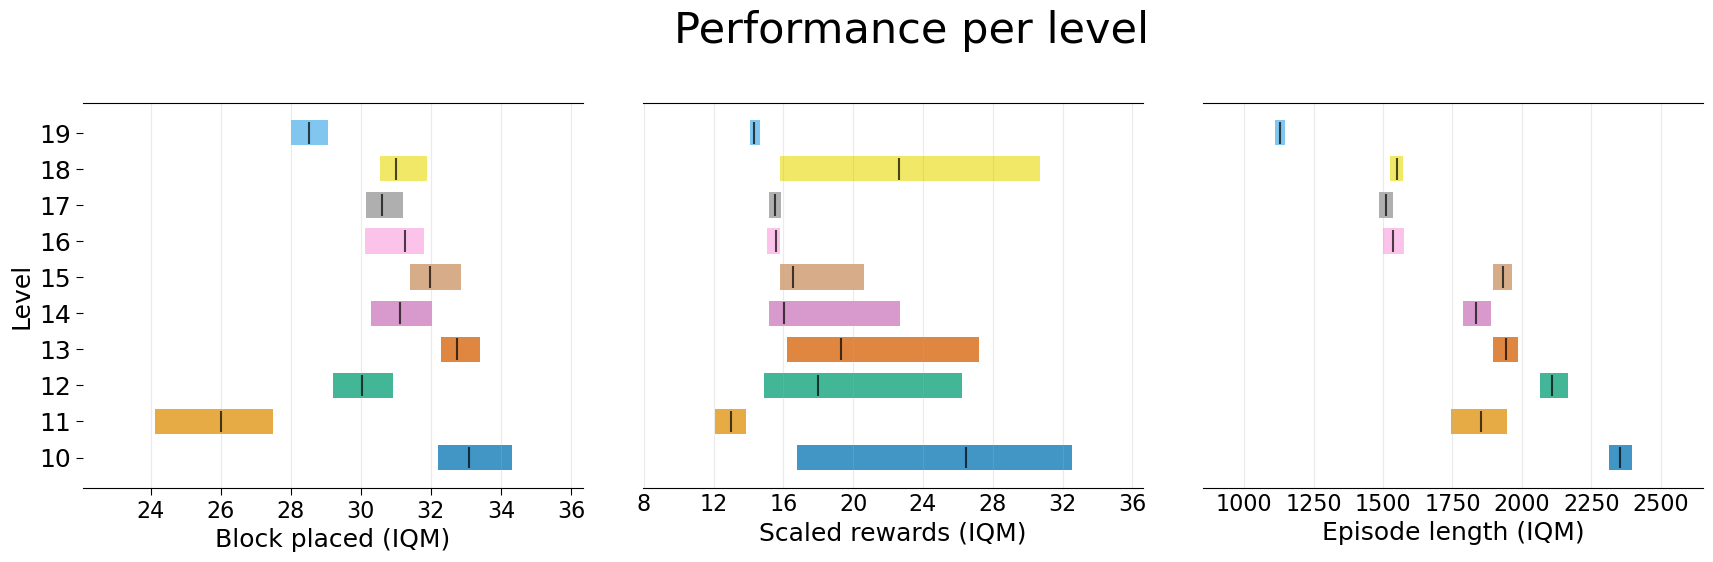

In [244]:
subpop = level_df[level_df["level"] > 9]
plot_interval(subpop, "Performance per level", subpop.parameter.unique(), subpop.level.unique())

In [213]:
level_data_mean = []
for i, parameter in enumerate(["block_placed", "scaled_rewards", "episode_length"]):
    for i in range(10):
        data_level = data[data["level"] == i+10]
        stats, lb, ub, mean, std = confidence_intervals(data_level, parameter, aggregate="mean")
        level_data_mean.append([stats, lb, ub, mean, std, i + 10, parameter])

level_df_mean = pd.DataFrame(
    level_data_mean,
    columns=["stat", "lower_bound", "upper_bound", "mean", "std", "level", "parameter"],
).drop(columns=['stat'])
level_df["width"] = level_df["upper_bound"] - level_df["lower_bound"]
level_df_mean.head()

,lower_bound,upper_bound,mean,std,level,parameter
0,31.69000,33.01,32.358460,0.335310,10,block_placed
1,23.70000,25.88,24.777054,0.560467,11,block_placed
2,30.76000,31.79,31.269204,0.263435,12,block_placed
3,29.62975,31.26,30.470336,0.416650,13,block_placed
4,29.77000,31.56,30.670372,0.456830,14,block_placed


In [214]:
level_df

,lower_bound,upper_bound,mean,std,level,parameter,width
0,32.019222,33.560653,33.026513,0.361577,10,block_placed,1.541432
1,22.764679,26.259278,24.749533,0.799958,11,block_placed,3.494599
2,30.476923,31.769262,30.927167,0.342753,12,block_placed,1.292339
3,29.542373,32.030315,30.567763,0.621174,13,block_placed,2.487942
4,29.480769,31.460107,30.411860,0.509486,14,block_placed,1.979338
5,31.017544,32.456178,31.772923,0.382624,15,block_placed,1.438634
6,30.304348,31.500000,30.692941,0.318663,16,block_placed,1.195652
7,28.754372,30.893959,29.835313,0.542445,17,block_placed,2.139587
8,30.564466,31.600000,31.185445,0.265776,18,block_placed,1.035534
9,28.086372,29.015879,28.428464,0.244320,19,block_placed,0.929507


(<Figure size 1800x500 with 3 Axes>,
 array([<Axes: xlabel='Block placed (mean)', ylabel='Level'>,
        <Axes: xlabel='Scaled rewards (mean)'>,
        <Axes: xlabel='Episode length (mean)'>], dtype=object))

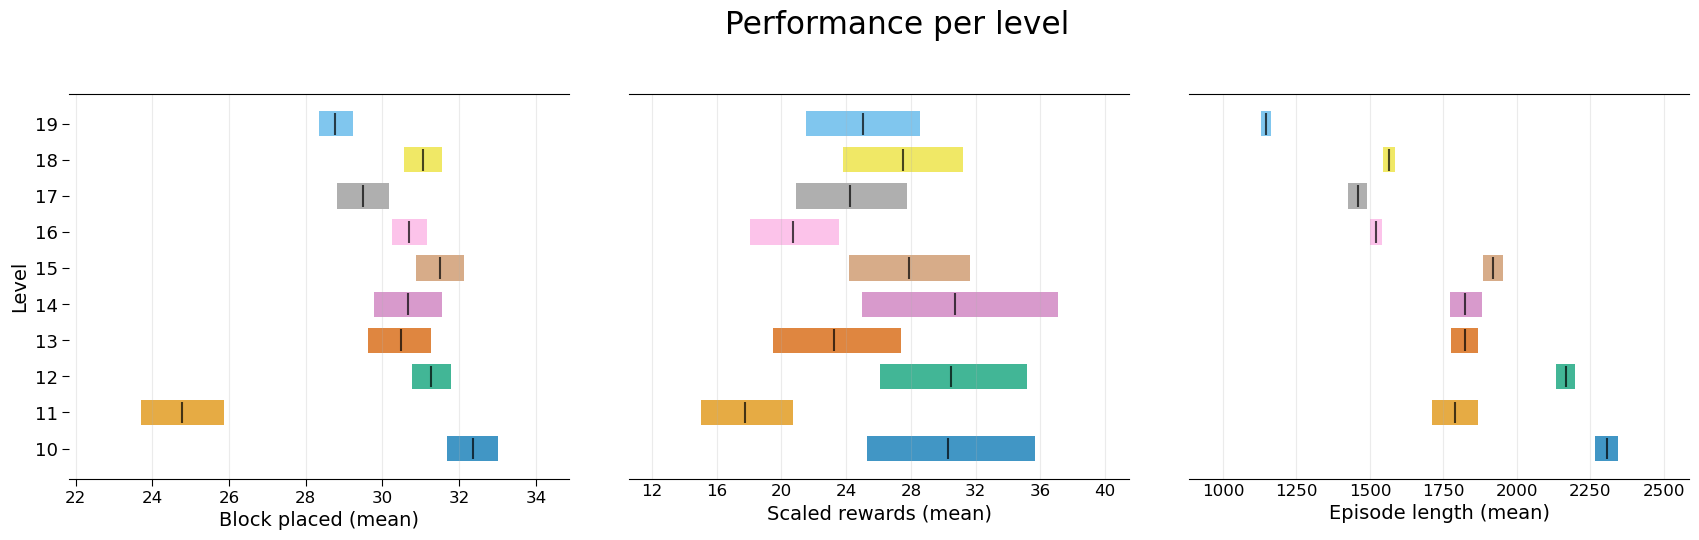

In [215]:
subpop_mean = level_df_mean[level_df_mean["level"] > 9]
plot_interval(subpop_mean, "Performance per level", subpop_mean.parameter.unique(), subpop_mean.level.unique(), agg="mean")

In [216]:
# [32.26, 35.40]
# [23.23, 26.71]
# [30.53, 31.84]
# [30.51, 32.08]
# [30.46, 31.13]
# [30.38, 32.11]
# [30.07, 31.46]
# [28.90, 30.81]
# [30.52, 32.06]
# [27.30, 28.67]

In [217]:
level_df.set_index("parameter")[["lower_bound", "upper_bound", "level"]].round(2)

,lower_bound,upper_bound,level
parameter,,,
block_placed,32.02,33.56,10
block_placed,22.76,26.26,11
block_placed,30.48,31.77,12
block_placed,29.54,32.03,13
block_placed,29.48,31.46,14
block_placed,31.02,32.46,15
block_placed,30.30,31.50,16
block_placed,28.75,30.89,17
block_placed,30.56,31.60,18


In [218]:
level_df.set_index("parameter").round(3)

,lower_bound,upper_bound,mean,std,level,width
parameter,,,,,,
block_placed,32.019,33.561,33.027,0.362,10,1.541
block_placed,22.765,26.259,24.750,0.800,11,3.495
block_placed,30.477,31.769,30.927,0.343,12,1.292
block_placed,29.542,32.030,30.568,0.621,13,2.488
block_placed,29.481,31.460,30.412,0.509,14,1.979
block_placed,31.018,32.456,31.773,0.383,15,1.439
block_placed,30.304,31.500,30.693,0.319,16,1.196
block_placed,28.754,30.894,29.835,0.542,17,2.140
block_placed,30.564,31.600,31.185,0.266,18,1.036


In [219]:
level_df.set_index("parameter").to_csv("UNREAL-eval/transfer/CI.csv")

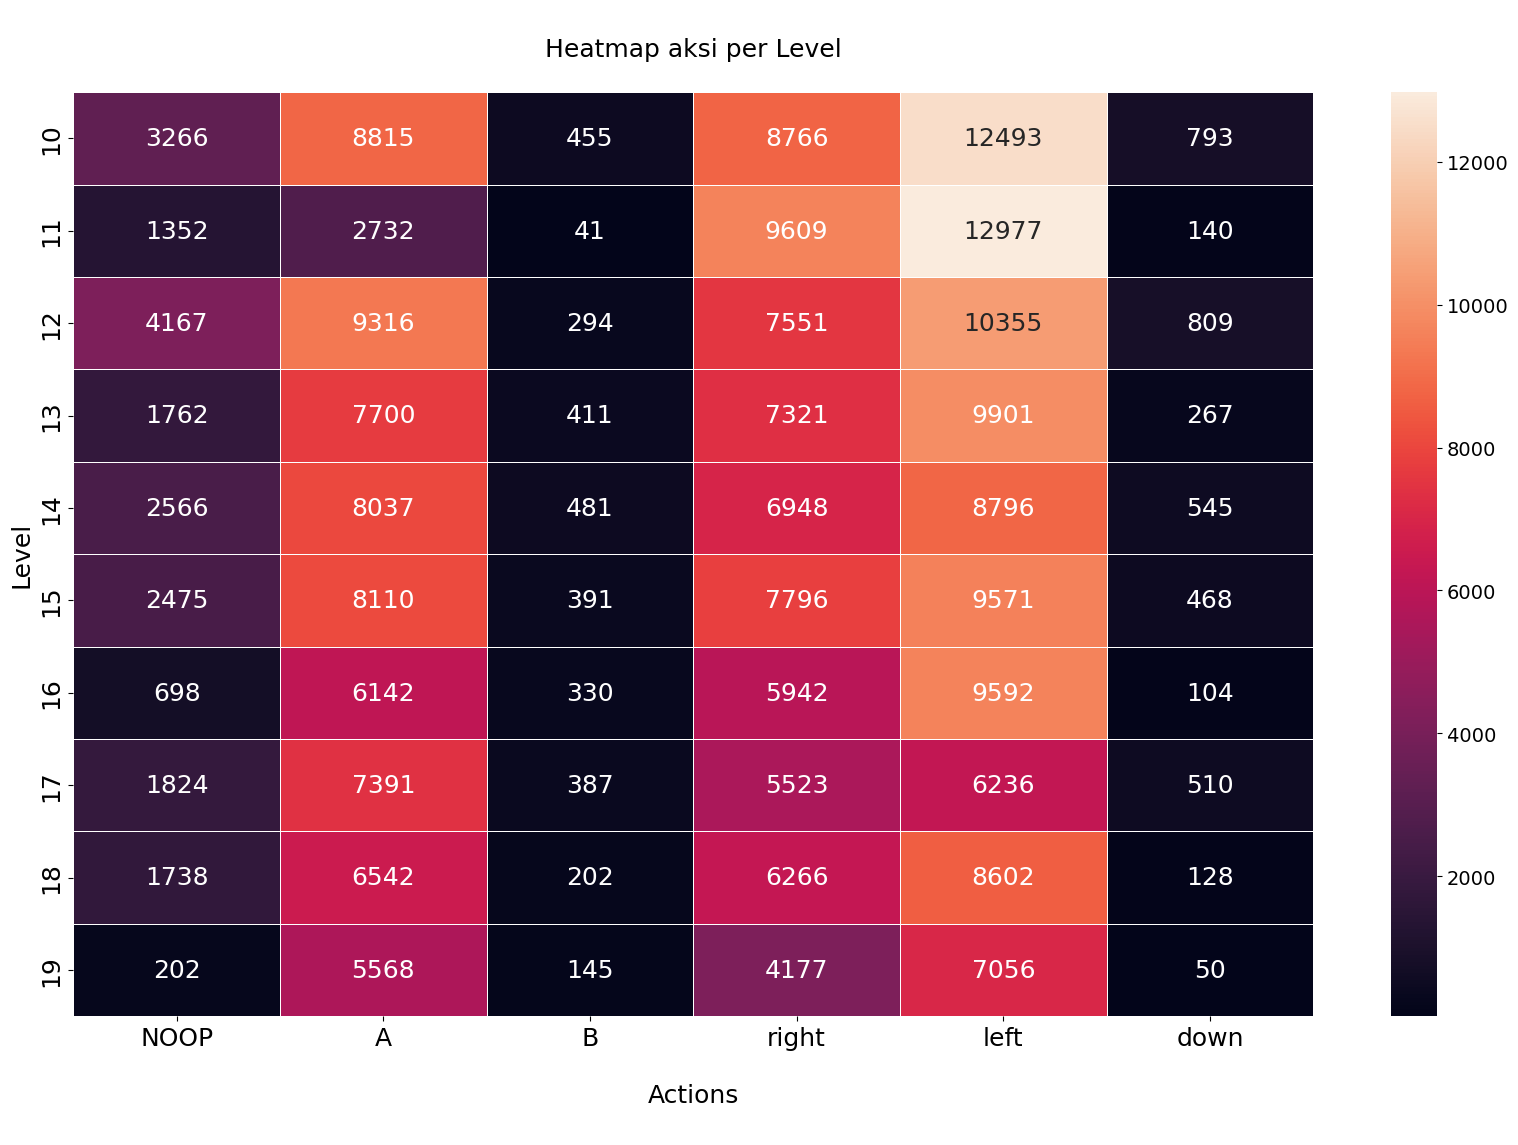

In [220]:
plt.figure(figsize=(20, 12))  # You can adjust the size
ax = sns.heatmap(action_data, annot=True, fmt='d', linewidths=0.5, yticklabels=action_data.index, annot_kws={"size": 18})

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)  # Ukuran font ticks colorbar

# Add labels and title
plt.title('\nHeatmap aksi per Level\n', fontsize=18)
plt.xlabel('\nActions\n', fontsize=18)
plt.ylabel('Level', fontsize=18)

# Show the heatmap
plt.show()

In [221]:
summary_df = data.groupby("level").agg(
    avg_reward=("scaled_rewards", "mean"),
    avg_blocks=("block_placed", "mean"),
    avg_episode_length=("episode_length", "mean"),
    avg_lines=("lines", "mean"),
    avg_softdrop=("softdrop_rewards", "mean")
).reset_index()

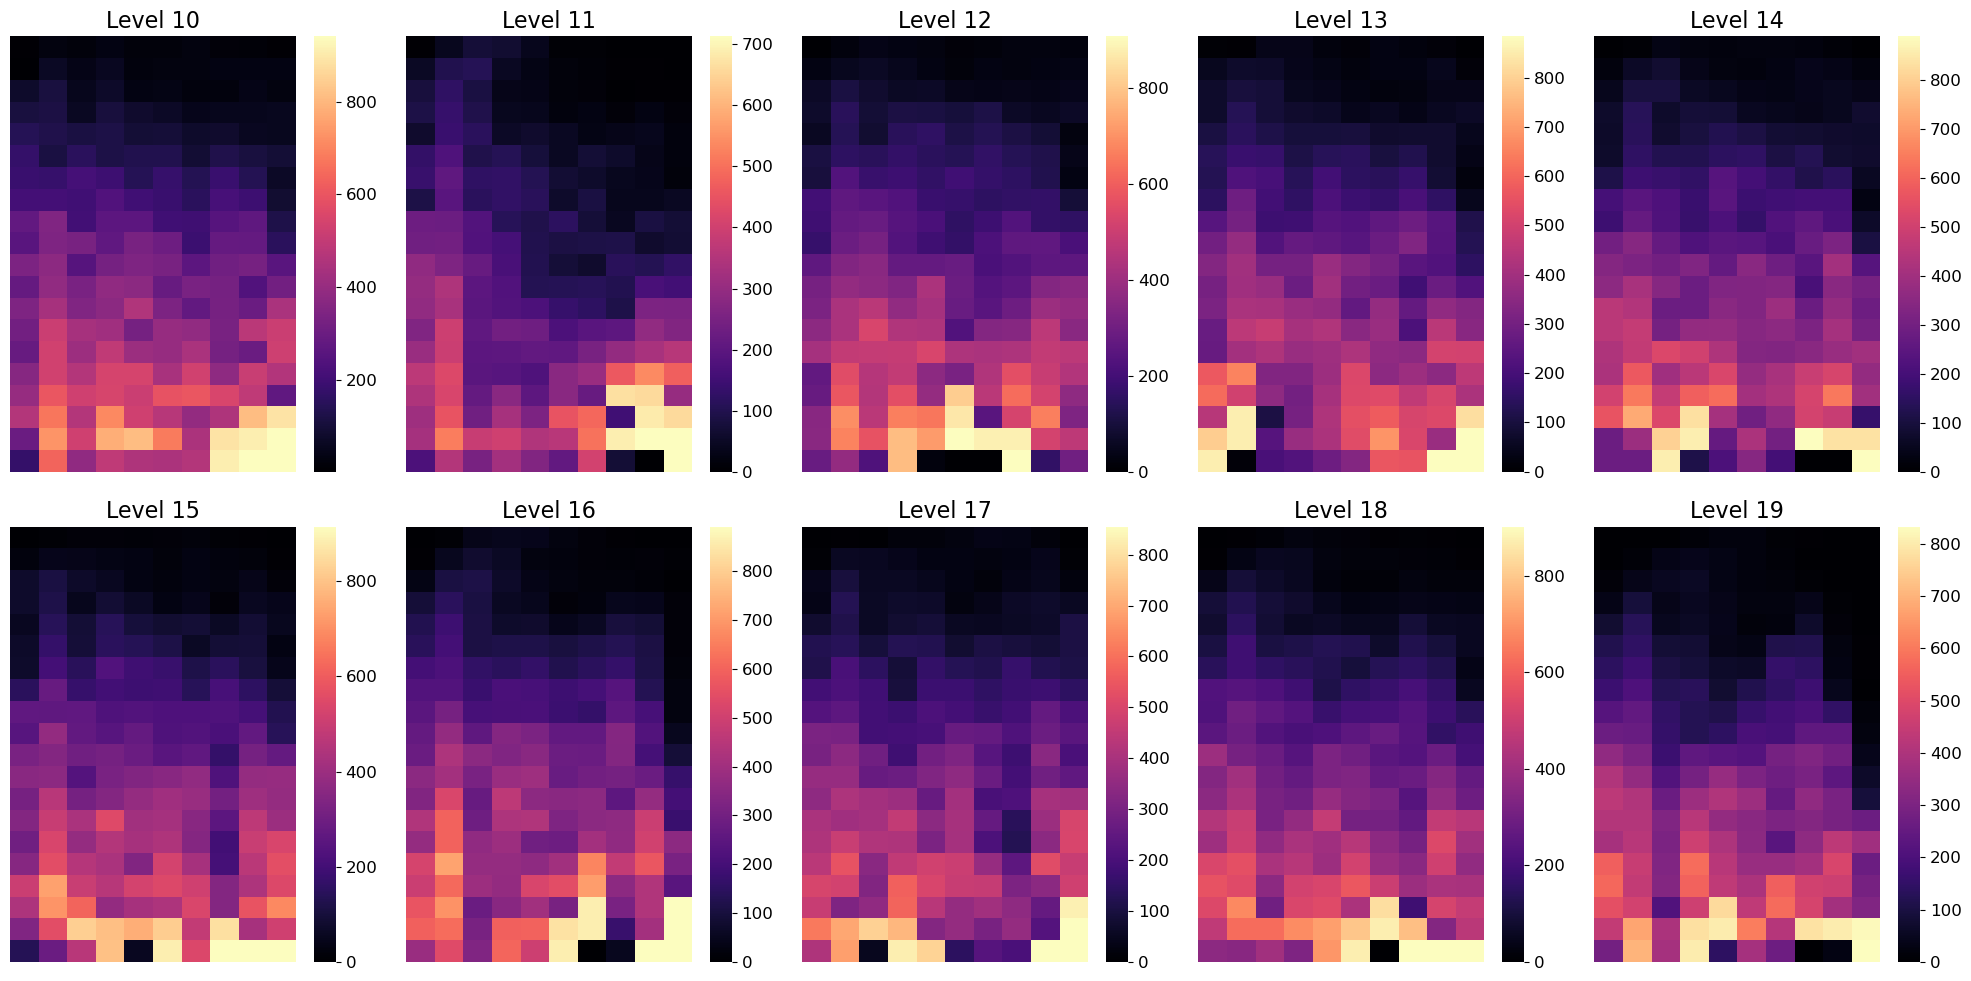

In [222]:
board_heatmap = data.groupby('level')["board_history"].sum()

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

# Loop melalui level 10 - 19 dan plot heatmap dalam subplots
for i in range(10):
    # Plot heatmap dalam subplot
    sns.heatmap(board_heatmap[i+10], cmap='magma', annot=False,  ax=axes[i])
    axes[i].set_title(f'Level {i+10}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()